# NOTE:

**Version 4 only include methods to identify TF regulators or targets. Use V3 for previous methods, and chromVAR plots.** 

In [1]:
library(repr)
options(repr.plot.width=10, repr.plot.height=10)

In [2]:
library(tidyverse)
library(chromVAR)
library(motifmatchr)
library(Matrix)
library(SummarizedExperiment)
library(BSgenome.Hsapiens.UCSC.hg38)
library(TFBSTools)
library(BiocParallel)
register(MulticoreParam(8))
set.seed(2019)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“no function found corresponding to methods exports from ‘AnnotationDbi’ for: ‘toTable’”


Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCal

In [3]:
library(WriteXLS)
library(naturalsort)
library(pheatmap)

In [4]:
setwd("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/")

In [5]:
# custom function to check if a motifname contains a hit gene name or TF gene name
# the reason is motifname sometimes contains "(var.2)" or other characters
mystrfunc <- function(motifname, target_match) {
    # motifname: scalar string value, name of the motif: eg. TFAP4(var.2)
    # target_match: vector, either Tf list of Hit list, or any gene list
    # returns T/F
    checkname <- function(x) {
        if (str_detect(motifname, paste0("^", x, "$"))) {
            check <- TRUE
        } else if (str_detect(motifname, paste0(":", x, "$"))) {
            check <- TRUE
        } else if (str_detect(motifname, paste0("^", x, ":"))) {
            check <- TRUE
        } else {
            check <- FALSE
        }
    }
    test <- map_lgl(target_match, ~ checkname(.x)) %>% any
    #test <- map_lgl(target_match, ~ if (str_detect(motifname, paste0("^", .x, "$"))) {TRUE} else if (str_detect(motifname, paste0(":", .x, "$"))) {TRUE} else if (str_detect(motifname, paste0("^", .x, ":"))) {TRUE} else {FALSE})
    #test <- map_lgl(target_match, ~ str_detect(string = motifname, pattern = paste0("^", .x, "$")) | str_detect(string = motifname, pattern = paste0(":", .x, "$")) | str_detect(string = motifname, pattern = paste0("^", .x, ":")))
    return(test)
}

# chromVAR analysis 1 - chromVAR + Jaspar 2020 motifs
**Inputs**
1. *Peaks*: These are peaks centered at summit with uniform width of 500 bp as recommended by chromVAR. Files are under `/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/diffbind_consensu_min2overlap.bed`. First 3 columns are standard bed, the 4th column is peak intensity as calculated from MACS2.
2. *Annovation*: Jaspar 2020 motifs

In [6]:
samplesheet <- read.csv('samplesheet2.csv', stringsAsFactors = F)

# Peaks
peak.file <- "/c/groups/sanjana_lab/cdai/TFscreen/atac/diffbind/diffbind_consensu_min2overlap_NO_RECENTER.bed"
peaks <- getPeaks(peak.file, sort_peaks = F)
#peaks <- resize(peaks, width = 500, fix = "center")
# do not resize to 500 bp, just use variable peak width directly from macs2

bed.files <- list.files(".", "*.PE.mapq.bed", recursive=T) %>% naturalsort # bam2bed files for read counts

fragment_counts <- getCounts(alignment_files = bed.files, peaks = peaks, paired = T, format = "bed")
fragment_counts.addGC <- addGCBias(fragment_counts, genome = BSgenome.Hsapiens.UCSC.hg38)
#fragment_counts.filtered <- filterPeaks(fragment_counts.addGC, min_fragments_per_peak = 10, non_overlapping = T)

Warning message in getPeaks(peak.file, sort_peaks = F):
“Peaks are not equal width!Use resize(peaks, width = x, fix = "center") to make peaks equal in size, where x is the desired size of the peaks)”
Warning message in getPeaks(peak.file, sort_peaks = F):
“Peaks not sorted”


ERROR: Error: stop worker failed:
  attempt to select less than one element in OneIndex


### Annotations

Get JASPAR2020 motifs. Then construct a motif - gene_name lookup table. In addition, add columns to indicate if a motif is a TF or hit TF.

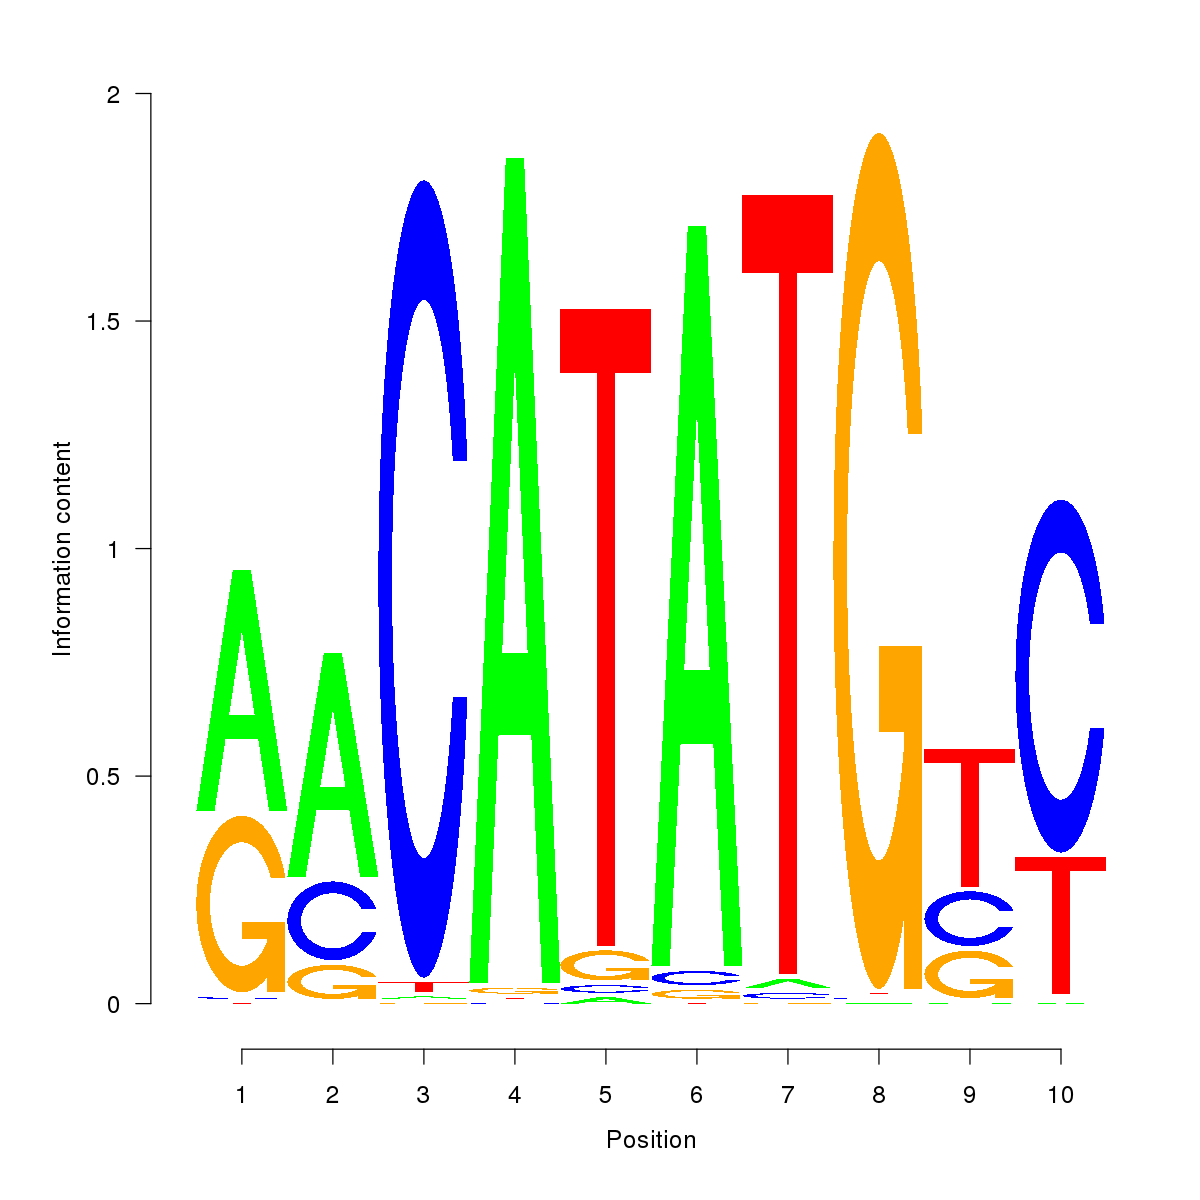

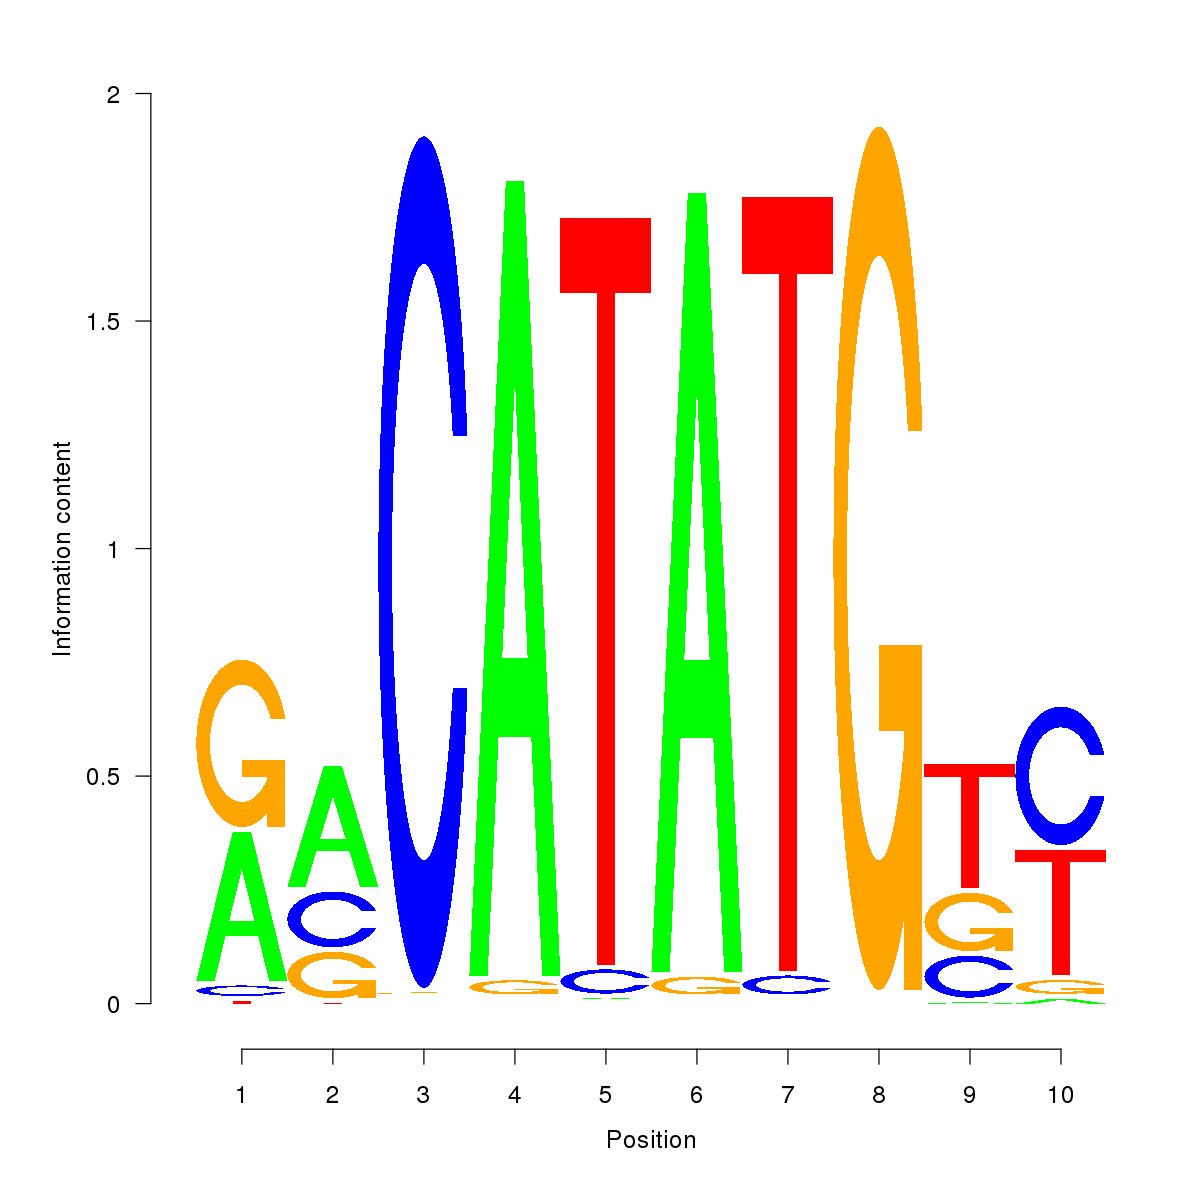

In [47]:
TFBSTools::toPWM(jaspar_2020$NEUROG2@profileMatrix, type = "prob") %>% seqLogo
TFBSTools::toPWM(jaspar_2020$NEUROG1@profileMatrix, type = "prob") %>% seqLogo
#TFBSTools::toPWM(jaspar_2020$VAX2@profileMatrix, type = "prob") %>% seqLogo

In [ ]:
# New method: use downloaded JASPAR2020
jaspar_2020 <- readJASPARMatrix("JASPAR2020_combined_matrices_20191030.txt", matrixClass = "PFM")

# read in hit list and TF list, note the gene names are matched and transformed to be consistent with approved symbols according to HGNC genenames.org
# hit list from crispr screen
hitlist <- read.csv('/c/groups/sanjana_lab/cdai/TFscreen/Hitlist_20191230.csv', stringsAsFactors=F) %>% pull(hgnc_symbol)
# genomewide TF list
tflist <- read.csv('/c/groups/sanjana_lab/cdai/TFscreen/TFlist_20191230.csv', stringsAsFactors=F) %>% pull(hgnc_symbol)

In [ ]:
# construct base motif_lookup table
motif_lookup <- TFBSTools::name(jaspar_2020) %>% 
                data.frame(stringsAsFactors = F) %>% 
                rownames_to_column("motif") %>% 
                mutate(gene_name=str_extract(`.`, "[a-zA-Z:0-9\\-]+")) %>%
                select(motif, gene_name)

# add two columns to indicate whether the motif is a TF or is a Hit
motif_lookup <- motif_lookup %>% mutate(is_hit = map_chr(gene_name, ~ if_else(mystrfunc(.x, hitlist), "Yes", "No"))) %>%
        mutate(is_tf = map_chr(gene_name, ~ if_else(mystrfunc(.x, tflist), "Yes", "No")))
# motif names of (almost) all TFs
tf.motif.list <- motif_lookup %>% filter(is_tf == "Yes") %>% pull(motif)

### Calculate chromVAR deviations

In [ ]:
# get motif matches with peaks
motif_ix <- matchMotifs(jaspar_2020, fragment_counts.addGC, genome = BSgenome.Hsapiens.UCSC.hg38)

# computing deviations
dev <- computeDeviations(object = fragment_counts.addGC, annotations = motif_ix)

---

#### TF Motif Deviations

In [ ]:
dev.scores <- deviationScores(dev) %>% # get deviation
                as.data.frame %>% rownames_to_column("motif") %>%
                left_join(motif_lookup[, c("motif", "gene_name")], by = "motif") %>%
                select(gene_name, ATAC1.PE.mapq.bed:ATAC12.PE.mapq.bed) %>%
                group_by(gene_name) %>% summarise_all(mean)

names(dev.scores) <- c("gene_name", paste0("A", 1:12))

In [ ]:
A <- paste0("A", c(1,3,5,7,9,11))
B <- paste0("A", c(2,4,6,8,10,12))
dev.scores.byTime <- map2(A, B, ~ (dev.scores[[.x]] + dev.scores[[.y]]) / 2 )
names(dev.scores.byTime) <- factor(c("ES", "H1", "H4", "H16", "D1", "D5"), levels = c("ES", "H1", "H4", "H16", "D1", "D5"))
dev.scores.byTime <- do.call(cbind, dev.scores.byTime)
rownames(dev.scores.byTime) <- dev.scores$gene_name

In [ ]:
dev.scores.byTime <- dev.scores.byTime %>% as.data.frame %>%
            rownames_to_column("gene_name") %>% left_join(unique(motif_lookup[,c("gene_name", "is_hit", "is_tf")]), by = "gene_name")

##### Density plot of TF changes over time course

In [ ]:
dev.Changes <- dev.scores.byTime %>% select(H1:D5) %>% apply(2, function(x) x - dev.scores.byTime$ES) %>% as.data.frame %>%
            add_column("gene_name" = dev.scores.byTime$gene_name, "is_hit" = dev.scores.byTime$is_hit, "is_tf" = dev.scores.byTime$is_tf, .before="H1" )

In [ ]:
dev.changes.gathered <- gather(dev.Changes, "Time", "Change", H1:D5)
dev.changes.gathered$Time <- factor(dev.changes.gathered$Time, levels = c("H1", "H4", "H16", "D1", "D5"))

In [ ]:
dev.changes.gathered %>% filter(., is_hit == "No") %>%
    ggplot(.) + geom_density(aes( x = Change, fill = Time),  alpha = .5) +
            coord_cartesian(xlim = c(-20, 20)) + 
            labs(title = "(Non-hit) TF motifs deviation z-score changes vs. ES", x = "Deviation z-score") 

In [ ]:
dev.changes.gathered %>% filter(is_hit == "Yes") %>%
    ggplot(.) + geom_density(aes( x = Change, fill = Time),  alpha = .5) +
                coord_cartesian(xlim = c(-20, 20)) + 
                labs(title = "(Hit) TF motifs deviation z-score changes vs. ES", x = "Deviation z-score") 
            

Individual motif deviation across time

D1 vs. ES

In [ ]:
D5_ES.dev <- map2_dbl(dev.scores.byTime$D5, dev.scores.byTime$ES)

#### Correlations of TF motifs

In [ ]:
dev.scores.t <- dev.scores %>% column_to_rownames("gene_name") %>% t

dev.score.corr <- apply(dev.scores.t, 2, function(x) map_dbl(as.data.frame(dev.scores.t), ~ cor(.x, x)))

In [ ]:
setdiff

In [ ]:
dev.score.corr %>% head

In [ ]:
dev.score.corr[which(! colnames(dev.score.corr) %in% hitlist), 
               which(! colnames(dev.score.corr) %in% hitlist)] %>%
    pheatmap(., cluster_rows = T, cluster_cols = T, treeheight_row = 0, 
             treeheight_col = 0, show_rownames = F, show_colnames = F, 
             main = "TF Correlation (Non-Hit TF Motifs)")

In [ ]:
dev.score.corr %>%
            .[intersect(hitlist, motif_lookup$gene_name), ] %>% 
            .[, intersect(hitlist, motif_lookup$gene_name)] %>%
            pheatmap(cluster_rows = T, cluster_cols = T, treeheight_col = 0, treeheight_row = 0,
                     show_rownames = T, show_colnames = T, 
                     main = "TF Correlation (Hit TF Motifs)")

#### Variability by motifs

In [540]:
dev.var <- computeVariability(dev)

In [542]:
head(motif_lookup)

motif,gene_name,is_hit,is_tf
<chr>,<chr>,<chr>,<chr>
THRB,THRB,No,Yes
THAP11,THAP11,No,Yes
TFAP4(var.2),TFAP4,No,Yes
TFAP2E,TFAP2E,No,Yes
TGIF2LY,TGIF2LY,No,Yes
TGIF2LX,TGIF2LX,No,Yes


In [563]:
dev.var %>% rename("name" = "motif") %>% 
    left_join(motif_lookup[, c("motif", "gene_name")], by = "motif") %>% 
    select(-motif) %>% 
    group_by(gene_name) %>% 
    summarise_all("max") %>% filter(p_value_adj < 1e-3) %>% 
    arrange(desc(variability)) %>%
    top_n(50, variability)

Warning message:
“Column `motif` joining factor and character vector, coercing into character vector”


gene_name,variability,bootstrap_lower_bound,bootstrap_upper_bound,p_value,p_value_adj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NEUROD1,32.02660,21.832545,36.28197,0.000000e+00,0.000000e+00
NEUROG2,30.61828,20.935405,34.54373,0.000000e+00,0.000000e+00
TAL1::TCF3,22.78724,15.374460,26.15693,0.000000e+00,0.000000e+00
HAND2,22.78075,15.539325,26.35482,0.000000e+00,0.000000e+00
ATOH7,19.45608,13.334609,22.15597,0.000000e+00,0.000000e+00
ATOH1,17.77563,11.881957,20.25011,0.000000e+00,0.000000e+00
ZEB1,17.25123,9.945931,20.50296,0.000000e+00,0.000000e+00
TWIST1,14.29257,9.313501,16.99315,0.000000e+00,0.000000e+00
SNAI1,13.95026,10.207127,15.83429,0.000000e+00,0.000000e+00


In [6]:
dev.var %>% rename("name" = "motif") %>% 
    left_join(motif_lookup[, c("motif", "gene_name")], by = "motif") %>% 
    select(-motif) %>% 
    group_by(gene_name) %>% 
    summarise_all("max") %>% filter(p_value_adj < 1e-3) %>% 
    arrange(desc(variability)) %>%
    top_n(250, variability) %>%
    ggplot(aes(x = gene_name, y = variability)) +
        geom_point(stat = "identity", alpha = .8) + geom_jitter()

ERROR: Error in eval(lhs, parent, parent): object 'dev.var' not found


In [565]:
str(assays(dev))

Formal class 'SimpleList' [package "S4Vectors"] with 4 slots
  ..@ listData       :List of 2
  .. ..$ deviations: num [1:639, 1:12] 0.01151 0.00387 -0.07643 0.0124 -0.05727 ...
  .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. ..$ : chr [1:639] "THRB" "THAP11" "TFAP4(var.2)" "TFAP2E" ...
  .. .. .. ..$ : chr [1:12] "ATAC1.PE.mapq.bed" "ATAC2.PE.mapq.bed" "ATAC3.PE.mapq.bed" "ATAC4.PE.mapq.bed" ...
  .. ..$ z         : num [1:639, 1:12] 5.55 2.14 -16.93 5.48 -12.97 ...
  .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. ..$ : chr [1:639] "THRB" "THAP11" "TFAP4(var.2)" "TFAP2E" ...
  .. .. .. ..$ : chr [1:12] "ATAC1.PE.mapq.bed" "ATAC2.PE.mapq.bed" "ATAC3.PE.mapq.bed" "ATAC4.PE.mapq.bed" ...
  ..@ elementType    : chr "ANY"
  ..@ elementMetadata: NULL
  ..@ metadata       : list()


---

## Find TF targets or regulators

Current method: 

1. Use `motifMatch` to match motif to each of the 116K peaks (each peak has its respective read counts).
2. Select only ranges that have a match to motifs
3. Get the read counts of a given regulator or target:
    - For a given regulator, get read counts of all the peaks (ranges) that has this binding motif, sum normalized counts
    - For a given target, get read counts of all the peaks (ranges) that ca bind to the motif, sum normalized counts

---

#### Support functions for this section 


In [12]:
getBindingTargetsMatrix <- function(motif_name, motif.matches, genomic.features, min.overlap = 10, tflist) {
    ###### INPUTS: #####
    # motif_name: string, name of jaspar motif_name
    # motif.matches: matchMotif object, e.g. motifMatch() result of peaks and jaspar 2020 motifs
    # genomic.features: GenomicRanges object, e.g. a bed formated promoter region coordinates, converted into GRanges object
    # min.overlap: integer, minimum overlap in base pairs
    # tflist: vector, a list of gene_names. Note these gene names are some times not the same as motif names, hence the need of motif_lookup
    ##### OUTPUTS: #####
    # overlapped.target.readcount: dataframe, containing read counts of genes that are targets of a given regulator. 
    # Read counts sum of all peaks that match to the regulator's motif.
    
    match.matrix <- motifMatches(motif.matches) # get motif matches
    GRanges.index <- which(match.matrix[ , motif_name]) # get index of matching peaks
    matched.target.GRanges <- rowRanges(motif.matches)[GRanges.index] # get granges of matching peaks
    
    # intersect with genomic features
    target.intersect.feature <- GenomicRanges::findOverlaps(query = matched.target.GRanges, subject = genomic.features,
                                                           minoverlap = min.overlap, ignore.strand = T)
    overlapped.gene_names <- genomic.features[subjectHits(target.intersect.feature), ] %>%
                                as.data.frame %>%
                                pull(gene_name) # get gene names of motif-matching peaks that that overlaps a gene
    overlapped.target.readcount <- matched.target.GRanges[queryHits(target.intersect.feature), ] %>%
                                mcols %>% as.data.frame %>%
                                add_column("gene_name" = overlapped.gene_names) %>% # add gene_name to matched ranges
                                dplyr::select(gene_name,A1:A12) %>%
                                filter(gene_name %in% tflist) %>% # make sure it's in the TF list
                                group_by(gene_name) %>% summarise_all(sum)
                                
    return(overlapped.target.readcount)
}

In [13]:
getRegulatorsMatrix <- function(gene_name, motif.matches, genomic.features, min.overlap = 10, tf.motif.list) {
    ###### INPUTS: #####
    # gene_name: string, gene name
    # motif.matches: matchMotif object, e.g. motifMatch() result of peaks and jaspar 2020 motifs
    # countGRanges: GenomicRanges object, e.g. a normalized read matrix, converted into GRanges object
    # genomic.features: GenomicRanges object, e.g. a bed formated promoter region coordinates, converted into GRanges object
    # min.overlap: integer, minimum overlap in base pairs
    # tf.motif.list: vector, a list of TF motif names. 
    ##### OUTPUTS: #####
    # regulators.readcount: list, each element's name is a regulator's motif name, the values are
    # summarised readcounts of matching/overlapping peaks for this regulator
    
    match.matrix <- motifMatches(motif.matches)
    match.matrix.GRanges <- rowRanges(motif.matches)
    
    # get the genomic ranges of the querying gene
    gene.GRanges <- genomic.features[genomic.features$gene_name == gene_name]
    
    # intersect match.matrix with gene.GRanges
    match.intersect.gene <- GenomicRanges::findOverlaps(query = match.matrix.GRanges, subject = gene.GRanges,
                                                       minoverlap = min.overlap, ignore.strand = T)
    overlapped.match.index <- queryHits(match.intersect.gene)
    
    # get all the motif names that bind to this gene's region, based on atac-seq data
    # keep motif names of the motifs that have a match in peaks
    if (length(overlapped.match.index) == 1) { # if there's only one peak
        gene.regulators <- match.matrix[overlapped.match.index, ] %>% .[.] %>% names 
    } else { # if multiple peaks
        gene.regulators <- match.matrix[overlapped.match.index, ] %>% colSums %>% .[.>0] %>% names
    }
    # only select listed TFs
    gene.regulators <- gene.regulators[gene.regulators %in% tf.motif.list] 
    
    # for each regulator (motif), get the read counts of the binding sites
    regulators.readcount <- list()
    for (regulator in gene.regulators) {
        readcount <- match.matrix.GRanges[overlapped.match.index, ] %>% # get counts of peaks within querying gene
                        as.data.frame %>% select(A1:A12) %>% # get only count columns
                        `*`(match.matrix[overlapped.match.index, regulator]) %>% # multiply 0 or 1 based on if the peak has a match to this regulator or not
                        colSums() # sum up all the reads from peaks that match to the regulator binding site
        regulators.readcount[[regulator]] <- readcount

    }
    return(regulators.readcount)
}

---

In [14]:
# get annotated promoter region bed
gene_region <- read.table("Protein_coding_genes_Up_2k.bed", header = F, stringsAsFactors = F, 
                              col.names = c("seqname","start","end","gene_id","gene_name","strand")) %>% 
                                dplyr::select(seqname, start, end, strand, gene_id, gene_name)
# convert to GRanges object
gene_region <- GenomicRanges::makeGRangesFromDataFrame(gene_region, keep.extra.columns = T)

In [15]:
# match peaks with jaspar2020
matchPeaksWithJaspar <- matchMotifs(pwms = jaspar_2020, subject = my_counts_matrix.norm, genome = BSgenome.Hsapiens.UCSC.hg38, out = "matches")

---

In [17]:
getBindingTargetsMatrix("NEUROG2(var.2)", matchPeaksWithJaspar, gene_region, 10, tflist) %>% filter(str_detect(gene_name, "ZBTB18"))

gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZBTB18,1.650795,3.21885,3.656414,2.766371,5.595751,4.928782,6.979408,5.079553,4.68844,6.096342,11.29208,7.129847


In [20]:
getRegulatorsMatrix("TSC22D3", matchPeaksWithJaspar, gene_region[gene_region$gene_name == "TSC22D3"], 10, tf.motif.list) %>% 
            do.call(rbind, .) %>% as.data.frame %>% rownames_to_column("motif") %>% filter(str_detect(motif, "NEUROG"))

motif,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [1]:
getRegulatorsMatrix("TSC22D3", matchPeaksWithJaspar, gene_region[gene_region$gene_name == "TSC22D3"], 10, tf.motif.list) %>% do.call(rbind, .) %>% head

ERROR: Error in getRegulatorsMatrix("TSC22D3", matchPeaksWithJaspar, gene_region[gene_region$gene_name == : could not find function "%>%"


In [24]:
gene_region[gene_region$gene_name %in% c("TSC22D3","RCOR2","FOXN2","TBPL1","MLLT6","TCEA2", "CTNNB1")]

GRanges object with 7 ranges and 2 metadata columns:
      seqnames              ranges strand |            gene_id   gene_name
         <Rle>           <IRanges>  <Rle> |        <character> <character>
  [1]     chr2   48312637-48379295      + | ENSG00000170802.16       FOXN2
  [2]     chr3   41192741-41260096      + | ENSG00000168036.18      CTNNB1
  [3]     chr6 133950170-133990432      + | ENSG00000028839.10       TBPL1
  [4]    chr11   63911230-63919164      - |  ENSG00000167771.6       RCOR2
  [5]    chr17   38703542-38729803      + |  ENSG00000275023.4       MLLT6
  [6]    chr20   64047836-64072347      + | ENSG00000171703.17       TCEA2
  [7]     chrX 107713221-107779342      - | ENSG00000157514.16     TSC22D3
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

### A. Know regulators, find their targets

In [58]:
FOUND_TARGETS <- list()
#Regulators <- c("NEUROG2", "NEUROG1", "NEUROG2(var.2)", "ZBTB18", "POU3F2", "EBF1" ,"ISL2", "INSM1","SNAI2", "TSC22D3","RCOR2","FOXN2","TBPL1","E2F1","SCRT2","VAX2","PHOX2A","MLLT6","JUND","TCEA2")
Regulators <- read.table("geneListForRegulatorTargetSearch.txt", stringsAsFactors = F) %>% pull(V1)
#Regulators <- which(Regulators %in% motif_lookup$motif) %>% Regulators[.] # filter out the ones that are not in the motif database

In [73]:
"HOXB3" %in% motif_lookup$motif

[1] TRUE

In [70]:
setdiff(Regulators, motif_lookup$motif) %>% sort

[1] "AFF4"     "ARID1B"   "CBX4"     "FOXN2"    "LHX4"     "MECP2"   
 [7] "MLLT6"    "MPHOSPH8" "PRDM6"    "RAI14"    "RCOR2"    "TBPL1"   
[13] "TCEA2"    "THRA"     "TOX4"     "TSC22D"   "ZFP2"     "ZNF250"  
[19] "ZNF3"     "ZNF34"    "ZNF440"   "ZNF441"   "ZNF554"

In [35]:
# These TFs are not found in motif database
xxx <- c("NEUROG2", "NEUROG1", "NEUROG2(var.2)", "ZBTB18", "POU3F2", "EBF1" ,"ISL2", "INSM1","SNAI2", 
  "TSC22D3","RCOR2","FOXN2","TBPL1","E2F1","SCRT2","VAX2","PHOX2A","MLLT6","JUND","TCEA2", "CTNNB1") 
which(!xxx %in% motif_lookup$motif) %>% xxx[.]

[1] "TSC22D3" "RCOR2"   "FOXN2"   "TBPL1"   "MLLT6"   "TCEA2"   "CTNNB1"

In [36]:
for (regulator in Regulators) {
    regulator.gene_name <- motif_lookup[motif_lookup$motif == regulator, 'gene_name']
    x <- getBindingTargetsMatrix(regulator, matchPeaksWithJaspar, gene_region, 10, tflist)
    x["regulator"] <- regulator.gene_name
    x <- select(x, regulator, gene_name, A1:A12)
    FOUND_TARGETS[[regulator.gene_name]] <- x
}
FOUND_TARGETS <- do.call(rbind, FOUND_TARGETS)

### B. Know targets, find their regulators

In [46]:
FOUND_REGULATORS <- list()
Targets <- c("NEUROG2", "NEUROG1", "ZBTB18", "POU3F2", "EBF1" ,"ISL2", "INSM1","SNAI2", "TSC22D3","RCOR2","FOXN2","TBPL1","E2F1","SCRT2","VAX2","PHOX2A","MLLT6","JUND","TCEA2", "CTNNB1")

In [107]:
Targets <- read.table("geneListForRegulatorTargetSearch.txt", stringsAsFactors = F) %>% pull(V1)

In [110]:
Targets <- Targets[Targets %in% tflist]

In [106]:
"TSC22D3" %in% gene_region$gene_name

[1] TRUE

In [47]:
for (target in Targets) {
    y <- getRegulatorsMatrix(target, matchPeaksWithJaspar, gene_region, 10, tf.motif.list)
    y <- do.call(rbind, y) %>% as.data.frame
    y['target'] <- target
    y <- rownames_to_column(y, 'motif') %>% 
            left_join(motif_lookup[, c('motif', 'gene_name')], by = "motif") %>% 
            rename("gene_name" = "regulator") %>%
            select(regulator, target, A1:A12)
    FOUND_REGULATORS[[target]] <- y
}

In [48]:
FOUND_REGULATORS <- do.call(rbind, FOUND_REGULATORS)

In [49]:
WriteXLS(list(Targets=FOUND_TARGETS, Regulators=FOUND_REGULATORS), "Set_of_regulators_counts_by_time.xls")

In [3]:
FOUND_REGULATORS %>% filter(target == "ZBTB18" & str_detect(regulator, "NEU"))

ERROR: Error in eval(lhs, parent, parent): object 'FOUND_REGULATORS' not found


### Differential analysis on targets:

In [19]:
library(DESeq2)

In [158]:
FOUND_TARGETS.deseq <- FOUND_TARGETS %>% mutate("tf.pair" = paste(regulator,gene_name, sep = ":")) %>%
                select(tf.pair, A1:A12)

In [159]:
head(FOUND_TARGETS.deseq)

tf.pair,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NEUROG2:ABL1,59.612027,60.728975,49.15846,69.372078,52.360238,53.93496,41.17851,54.68986,44.86193,52.234566,61.353611,63.027849
NEUROG2:AEBP2,12.656092,9.656551,13.60999,6.383934,7.993929,11.54743,16.51793,11.85229,10.38811,6.512002,4.893233,4.563102
NEUROG2:AFF1,26.229292,33.261453,31.89206,38.516399,26.979512,30.55845,25.59116,26.92163,28.22257,27.710645,24.340696,23.671093
NEUROG2:AFF3,135.915421,142.487772,137.31866,144.276899,141.292702,140.68152,146.56756,165.25480,153.06377,153.655526,150.686477,160.991950
NEUROG2:AHR,28.063508,36.265713,36.36101,39.367591,35.173289,28.16447,30.01145,16.25457,32.08364,23.554048,11.417543,11.122562
NEUROG2:ALX3,8.070551,14.806711,11.98491,12.129474,12.990135,13.51894,14.65676,7.61933,10.93969,10.945705,8.029920,9.553995


In [160]:
FOUND_TARGETS.deseq[,2:13] <- apply(FOUND_TARGETS.deseq[,2:13], 2, as.integer)

In [161]:
sample.anno <- data.frame("sample" = paste0(rep("A",12),1:12), 
                          "condition" = c(rep("ES",2), rep("H1",2), rep("H4",2), rep("H16",2), rep("H24",2), rep("D5",2)))

In [162]:
sample.anno %>% t

sample,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
condition,ES,ES,H1,H1,H4,H4,H16,H16,H24,H24,D5,D5


In [163]:
dds.targets <- DESeqDataSetFromMatrix(countData = FOUND_TARGETS.deseq[,2:13], colData = sample.anno, design = ~ condition)

In [164]:
mcols(dds.targets) <- cbind(mcols(dds.targets), "tf.pair"=FOUND_TARGETS.deseq$tf.pair)

In [165]:
dds.targets <- DESeq(dds.targets)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
Warning message in lfproc(x, y, weights = weights, cens = cens, base = base, geth = geth, :
“Estimated rdf < 1.0; not estimating variance”final dispersion estimates
fitting model and testing


In [166]:
resultsNames(dds.targets)

[1] "Intercept"           "condition_ES_vs_D5"  "condition_H1_vs_D5" 
[4] "condition_H16_vs_D5" "condition_H24_vs_D5" "condition_H4_vs_D5"

In [169]:
res.targets.a <- results(dds.targets, contrast = c("condition", "D5", "ES"))

In [171]:
fdr <- 0.05
res.targets.a[which(res.targets.a$padj < fdr), ] %>% as.data.frame %>% add_column("tf.pair"=FOUND_TARGETS.deseq$tf.pair[which(res.targets.a$padj < fdr)])

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,tf.pair
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
146.6622431,0.4286594,0.1232722,3.477340,5.064160e-04,4.088833e-03,NEUROG2:AFF3
26.3350362,-1.2742763,0.3579525,-3.559904,3.709909e-04,3.238035e-03,NEUROG2:AHR
8.0479035,-2.9036434,1.0757727,-2.699123,6.952240e-03,3.262962e-02,NEUROG2:ANKRD42
8.8090902,1.6142051,0.5143416,3.138391,1.698779e-03,1.012147e-02,NEUROG2:ANKS1A
47.6285014,1.4059792,0.2286268,6.149669,7.764504e-10,8.116781e-08,NEUROG2:ARID1A
20.2296244,-0.9561344,0.3533861,-2.705637,6.817353e-03,3.261186e-02,NEUROG2:ASCC3
4.6876782,2.1407404,0.6652061,3.218161,1.290154e-03,8.228867e-03,NEUROG2:ATF3
1.0132321,4.7088744,1.5305313,3.076627,2.093569e-03,1.197187e-02,NEUROG2:ATF6
35.6538932,0.6310421,0.2272533,2.776823,5.489310e-03,2.772520e-02,NEUROG2:BAZ1B


---

## Get normalized read counts per gene from consensus peaks

Wrote a script for this: 
- path: `/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac`
- Rscript: `getATACseqReadcountsPerGene.R`
- Resulted read counts in: `ATAC-seq_readcounts_per_Gene.csv`

In [84]:
atac.counts.perGene <- read.csv("ATAC-seq_readcounts_per_Gene.csv")

In [138]:
atac.counts.perGene %>% head


gene_id,gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,is.hit,is.tf
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
ENSG00000187634.12,SAMD11,37.05117,48.28275,48.34592,46.38992,57.55629,36.61381,44.668209,40.636427,47.89563,51.54180,102.757889,88.552702,No,No
ENSG00000188976.11,NOC2L,30.63141,29.18424,39.61115,41.06997,41.96813,23.09486,28.382925,30.646639,37.87524,33.66843,54.703833,58.036956,No,No
ENSG00000187961.14,KLHL17,23.29455,20.17146,27.21997,31.91967,28.17860,17.46197,21.636164,20.995487,24.36150,20.64443,19.321996,24.954465,No,No
ENSG00000187583.10,PLEKHN1,11.55556,17.38179,15.23506,13.61906,12.79029,10.84332,8.142642,14.900023,11.49127,12.46979,5.896973,5.418684,No,No
ENSG00000187642.9,PERM1,14.85715,13.30458,17.26640,16.38543,13.58968,10.56168,15.819991,8.465922,10.75583,13.02400,12.421283,5.703878,No,No
ENSG00000188290.10,HES4,46.03883,51.50160,43.87697,46.38992,54.55857,38.86697,41.876446,45.885299,41.27666,44.05993,38.142122,39.641950,No,Yes


In [139]:
sample.anno <- data.frame("sample" = paste0(rep("A",12),1:12), 
                          "condition" = c(rep("ES",2), rep("H1",2), rep("H4",2), rep("H16",2), rep("H24",2), rep("D5",2)))

In [140]:
atac.counts <- select(atac.counts.perGene, A1:A12) %>% apply(., 2, as.integer)

In [147]:
dds.atac <- DESeqDataSetFromMatrix(countData = atac.counts, colData = sample.anno, design = ~ condition)

In [148]:
dds.atac <- DESeq(dds.atac)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [153]:
sample.anno %>% t

sample,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
condition,ES,ES,H1,H1,H4,H4,H16,H16,H24,H24,D5,D5


In [156]:
res.atac.a <- results(dds.atac, contrast = c("condition", "D5", "ES"))

In [157]:
fdr <- 0.01
res.atac.a[which(res.atac.a$padj < fdr), ] %>% as.data.frame %>% 
        add_column("gene_name"=atac.counts.perGene$gene_name[which(res.atac.a$padj < fdr)]) %>%
        cbind(counts(dds.atac)[which(res.atac.a$padj < fdr),])

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
53.96597,1.2859206,0.2555272,5.032421,4.843235e-07,4.171176e-05,SAMD11,37,48,48,46,57,36,44,40,47,51,102,88
36.98419,1.0500669,0.3035926,3.458802,5.425834e-04,7.509406e-03,NOC2L,30,29,39,41,41,23,28,30,37,33,54,58
85.93123,1.3913771,0.2120123,6.562719,5.283528e-11,2.881085e-08,ACAP3,61,60,50,66,95,75,67,79,89,93,141,150
41.82490,1.0333660,0.2768952,3.731975,1.899846e-04,3.502703e-03,PRXL2B,42,31,33,37,37,35,31,40,35,42,69,68
43.65750,-1.3623490,0.3017304,-4.515121,6.328074e-06,2.844690e-04,ARHGEF16,67,62,54,57,51,46,40,36,36,36,21,25
49.64993,0.9224558,0.2622441,3.517546,4.355565e-04,6.426952e-03,PARK7,37,43,47,37,38,39,54,51,50,61,69,70
186.76433,0.5528684,0.1481239,3.732473,1.896094e-04,3.502703e-03,RERE,171,174,187,171,167,175,165,180,189,204,239,225
44.46515,1.0083677,0.2684577,3.756152,1.725463e-04,3.269921e-03,PGD,37,40,29,37,38,34,50,43,37,45,70,72
27.16807,1.1758202,0.3428771,3.429276,6.051942e-04,8.100341e-03,UBIAD1,24,18,22,24,26,24,24,23,27,26,44,43


In [134]:
res.atac.b <- results(dds.atac, contrast = c("condition", "D5", "ES"))

In [137]:
fdr <- 0.01
res.atac.b[which(res.atac.b$padj < fdr), ] %>% as.data.frame %>% 
        add_column("gene_name"=atac.counts.perGene$gene_name[which(res.atac.b$padj < fdr)]) %>%
        cbind(counts(dds.atac)[which(res.atac.b$padj < fdr),])

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
53.96597,1.2859206,0.2555272,5.032421,4.843235e-07,4.171176e-05,SAMD11,37,48,48,46,57,36,44,40,47,51,102,88
36.98419,1.0500669,0.3035926,3.458802,5.425834e-04,7.509406e-03,NOC2L,30,29,39,41,41,23,28,30,37,33,54,58
85.93123,1.3913771,0.2120123,6.562719,5.283528e-11,2.881085e-08,ACAP3,61,60,50,66,95,75,67,79,89,93,141,150
41.82490,1.0333660,0.2768952,3.731975,1.899846e-04,3.502703e-03,PRXL2B,42,31,33,37,37,35,31,40,35,42,69,68
43.65750,-1.3623490,0.3017304,-4.515121,6.328074e-06,2.844690e-04,ARHGEF16,67,62,54,57,51,46,40,36,36,36,21,25
49.64993,0.9224558,0.2622441,3.517546,4.355565e-04,6.426952e-03,PARK7,37,43,47,37,38,39,54,51,50,61,69,70
186.76433,0.5528684,0.1481239,3.732473,1.896094e-04,3.502703e-03,RERE,171,174,187,171,167,175,165,180,189,204,239,225
44.46515,1.0083677,0.2684577,3.756152,1.725463e-04,3.269921e-03,PGD,37,40,29,37,38,34,50,43,37,45,70,72
27.16807,1.1758202,0.3428771,3.429276,6.051942e-04,8.100341e-03,UBIAD1,24,18,22,24,26,24,24,23,27,26,44,43


In [1]:
(966957 - 966157)/(969309 - 961310)

[1] 0.1000125